In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [2]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [3]:
def discrete_sine_transform(y):
    """
    y is the vector of coefficents of size n. It assumes that it only contains the frequencies 1,2,3,...,n. (no zero frequency)
    returns evaluation of the sine series at the points 1,2,3,...,n (no zero point)
    """
    n = y.shape[0]
    y_extended = jnp.concatenate([jnp.zeros(1), y, jnp.zeros(1), -y[::-1]])
    y_fft = jnp.fft.fft(y_extended)/2
    return (-y_fft.imag)[1: n+1]*jnp.sqrt(2)

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A


@jit
def compute_sine_coef_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    n = A.shape[0]
    return dst_2d(A)/((n+1)**2)

vmap_compute_sine_coef = jit(vmap(compute_sine_coef_2d, in_axes = 0))
@jit
def double_compute_sine_coef_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(compute_sine_coef_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(compute_sine_coef_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A



def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

In [4]:
kernel_name = "Matern"

In [5]:
if kernel_name == "Matern":
    # Defining the second order elliptic operators 
    def matern_kernel(x, y, length_scale):
        r = jnp.sqrt(jnp.sum((x - y) ** 2))
        return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

    vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
    # Now we apply vmap to the result to vectorize over the rows of the first argument
    vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

    # Defining the second order elliptic operators 
    def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
        r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
        return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

    matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

    def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])

        nu = 5/2
        l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
        l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
        l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
        return -(l_1 + l_2)

    def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])
        
        nu = 5/2
        l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
        l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
        return -(l_1 + l_2)

    def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])
        
        nu = 5/2
        l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_1 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_1)
        
        l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        l_2 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_2)

        return -(l_1 + l_2)
elif kernel_name == "RBF":
    # RBF kernel
    def matern_kernel(x, y, length_scale):
        r =jnp.sum((x - y) ** 2)
        return jnp.exp(-r/length_scale**2)

    vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
    # Now we apply vmap to the result to vectorize over the rows of the first argument
    vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

    # Defining the second order elliptic operators 
    def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
        r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
        return  jnp.exp(-r/length_scale**2)

    matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))
    def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
        return -(l_1 + l_2)

    def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        return -(l_1 + l_2)

    def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

        return -(l_1 + l_2)
else:
    print("Error, kernel name not recognize")

In [6]:
double_neg_laplacian_tensor = jit(vmap(vmap(vmap(vmap(double_neg_laplacian, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_x_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_x, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_y_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))

In [7]:
neg_laplacian_y_partial = vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None, None))
matern_kernel_partial = vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None,None))

In [8]:
@jit
def L_b_xy_tensor(x_1,x_2, y_1, y_2,length_scale, epsilon,b_1, b_2):
    return epsilon**2*double_neg_laplacian_tensor(x_1,x_2, y_1, y_2,length_scale) + epsilon*b_2[None, None]*neg_laplacian_x_tensor(x_1,x_2, y_1, y_2, length_scale) + epsilon*b_1[:, :, None, None]*neg_laplacian_y_tensor(x_1,x_2, y_1, y_2, length_scale) + b_1[:, :, None, None]*b_2[None, None]*matern_kernel_tensor(x_1,x_2, y_1, y_2, length_scale)
@jit
def L_b_y_partial(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_partial(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_partial(x_1, x_2, y_1, y_2, length_scale))

@jit 
def L_b_y_tensor(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_tensor(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_tensor(x_1, x_2, y_1, y_2, length_scale))

In [9]:
@jit
def build_matrices(boundary_points,x,y,length_scale, b_matrix, nu):
    n_boundary = boundary_points.shape[0]
    n_points = x.shape[0]
    theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
    theta_22_tensor = L_b_xy_tensor(x, y,x,y, length_scale, nu, b_matrix, b_matrix)
    theta_12_tensor = L_b_y_partial(boundary_points[:, 0],boundary_points[:, 1],  x, y, length_scale, nu, b_matrix)

    theta_22_dst_tensor = double_compute_sine_coef_2d(theta_22_tensor)
    theta_12_dst_tensor  = vmap_compute_sine_coef(theta_12_tensor)

    theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary,n_points*n_points))
    theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))
    theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])

    return theta, theta_11, theta_12_dst, theta_22_dst



def create_interior(x, y):
    # Use meshgrid to create the grid of pairs
    A, B = jnp.meshgrid(x, y, indexing='ij')

    # Combine A and B into pairs
    interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
    return interior

def predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix):
    n_eval = x_eval.shape[0]
    n_points =x.shape[0]
    interior_eval = create_interior(x_eval, y_eval)
    K_interior = L_b_y_tensor(x_eval, y_eval, x, y, length_scale, nu, b_matrix).reshape(n_eval*n_eval, n_points, n_points)
    K_interior = vmap_compute_sine_coef(K_interior)
    K_interior = K_interior.reshape(-1, (n_points)*(n_points))

    K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)
    K_eval = jnp.hstack([K_eval_bc, K_interior])


    pred = jnp.dot(K_eval, alpha)
    pred_grid = jnp.reshape(pred, (n_eval, n_eval))

    return pred_grid, pred
    


# Elliptic PDE

In [10]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u +u&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(\pi^2(l^2 + k^2) + 1)\sin(\pi k x) \sin(\pi l y) 


In [11]:
key = random.PRNGKey(647023)
#key = random.PRNGKey(558)


n_coef = 2**10
print("Number of coefficients: ", n_coef)

nu = 1e-1
b = lambda x, y: 1.0
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:] # make sure to exclude the points 0 and 1!
y_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x_finest, y_finest)
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef) + 1

delta = 0.025
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))


decay = (jnp.arange(1,n_coef + 1)[None]**2 + jnp.arange(1,n_coef+1)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))


Number of coefficients:  1024


In [12]:
s = 1 -2*delta # Where the right hand side lives (not included). The limit is H^{-1}
s

0.95

In [13]:
u_values = dst_2d(coef_u)
f_values = dst_2d(coef_laplacian) + vmap_b(x_finest, y_finest)*u_values

In [14]:
coef_f = compute_sine_coef_2d(f_values)
print(jnp.mean(jnp.abs(coef_u - compute_sine_coef_2d(u_values))))

1.6026921844310666e-19


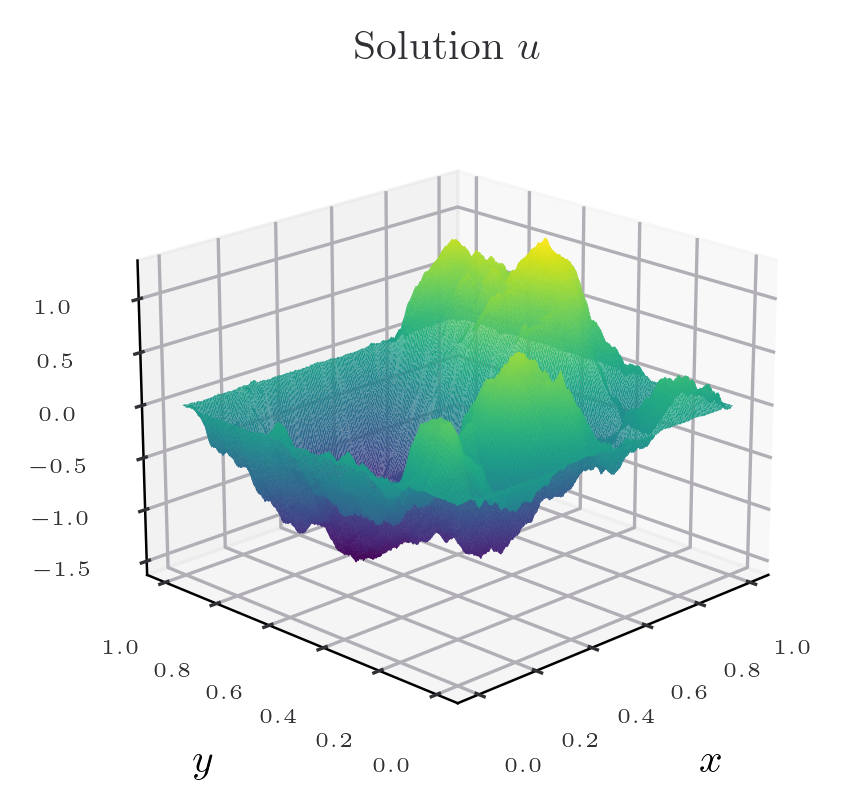

In [15]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 5
ax.plot_surface(X, Y,u_values,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

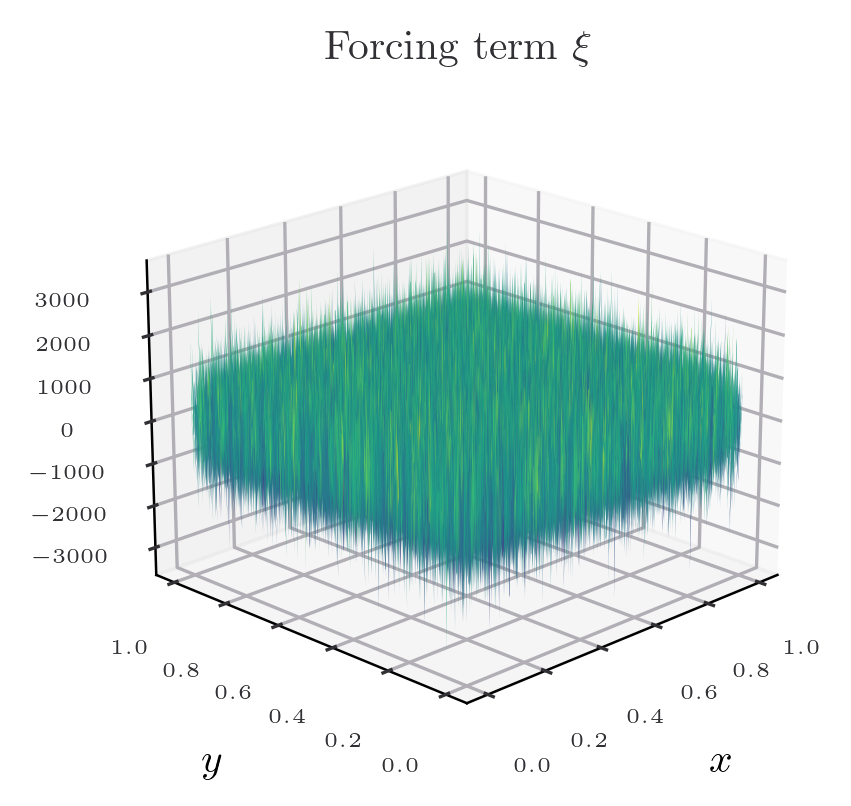

In [16]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

# Solve the linear PDE

In [17]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:] # remember to not include the points 0 and 1
y = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

Number of points 64 (4096 measurements)
(4096, 2)


In [18]:
# Create the boundary

# Create a boundary
# Boundary points
boundary = jnp.hstack([jnp.zeros(1), x, jnp.zeros(1)])
n_boundary = boundary.shape[0]
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 66 (264 total)


In [19]:
length_scale = 1.0
b_matrix = vmap_b(x, y)

In [20]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_f[:n_points,:n_points], (n_points)*(n_points))])

In [21]:
theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)

In [22]:
def solve(theta, boundary_condition, coef_forcing, s_decay, reg_bc = 1e-10, reg = 1e-7):
    n_points = coef_forcing.shape[0]
    n_boundary = boundary_condition.shape[0]
    rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_forcing, (n_points)*(n_points))])

    # Adaptive nugget
    decay_nugget =  (jnp.arange(1,n_points +1)[None]**2 + jnp.arange(1,n_points+1)[:,None]**2) 
    decay_nugget = decay_nugget.reshape((n_points)*(n_points))**(s_decay)
    nugget = jnp.hstack([jnp.ones(n_boundary)*reg_bc, decay_nugget*reg])

    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a='pos')
    return alpha


In [23]:
n_eval = 2**8
x_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
y_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

ratio = int(n_coef/n_eval)
u_eval = u_values[::ratio, ::ratio]


In [24]:
theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)

In [25]:
reg = 1e-12

In [26]:
s_decay = 1.0
decay_nugget =  (jnp.arange(1,n_points +1)[None]**2 + jnp.arange(1,n_points+1)[:,None]**2) 
decay_nugget = decay_nugget.reshape((n_points)*(n_points))**(-s_decay)
decay_nugget

Array([5.00000000e-01, 2.00000000e-01, 1.00000000e-01, ...,
       1.25944584e-04, 1.23992560e-04, 1.22070312e-04],      dtype=float64, weak_type=True)

## $L^2$ decay

In [27]:
t = 0.0
alpha = solve(theta, boundary_condition, coef_f[:n_points,:n_points], t, reg_bc = 1e-12, reg = reg)
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783692, dtype=float64), Array(0.02771304, dtype=float64))


## $H^{-1/2}$ decay

In [28]:
t = 0.5
alpha = solve(theta, boundary_condition, coef_f[:n_points,:n_points], t, reg_bc = 1e-12, reg = reg)
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783694, dtype=float64), Array(0.02771307, dtype=float64))


## $H^{-s}$ decay

In [29]:
t = s
alpha = solve(theta, boundary_condition, coef_f[:n_points,:n_points], t, reg_bc = 1e-10, reg = reg)
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783618, dtype=float64), Array(0.02771188, dtype=float64))


## $H^{-s - \varepsilon}$ decay

In [30]:
t = s + 0.01
alpha = solve(theta, boundary_condition, coef_f[:n_points,:n_points], t, reg_bc = 1e-10, reg = reg)
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783624, dtype=float64), Array(0.02771198, dtype=float64))


## $H^{-1}$ decay

In [31]:
t = 1
alpha = solve(theta, boundary_condition, coef_f[:n_points,:n_points], t, reg_bc = 1e-10, reg = reg)
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783655, dtype=float64), Array(0.02771247, dtype=float64))


In [32]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01783655, dtype=float64), Array(0.02771247, dtype=float64))


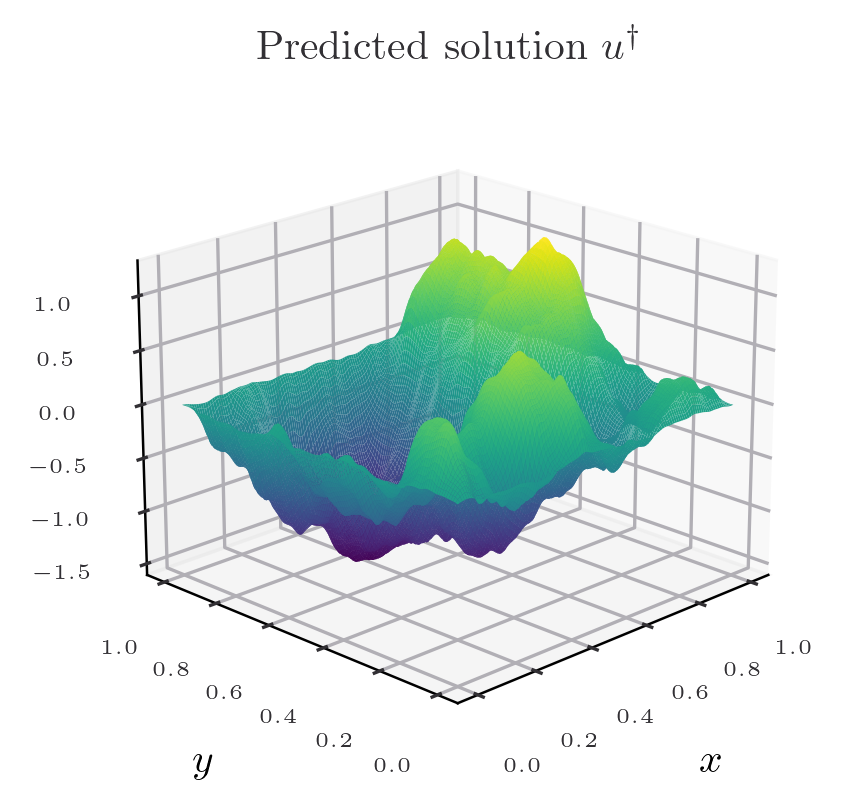

In [33]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})
stride = 2
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

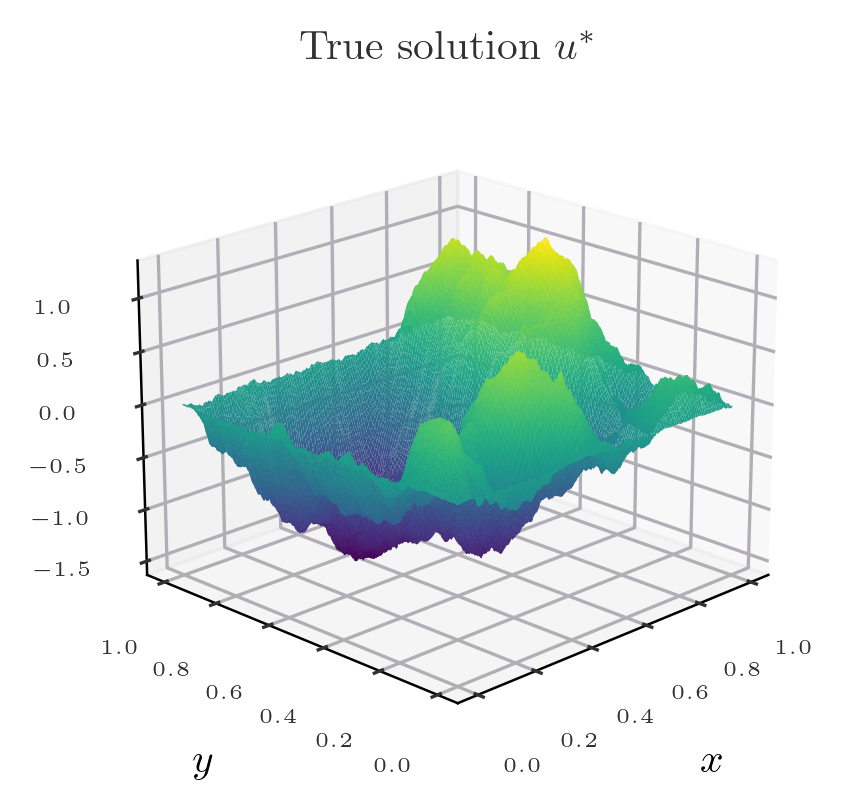

In [34]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})
stride =2
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

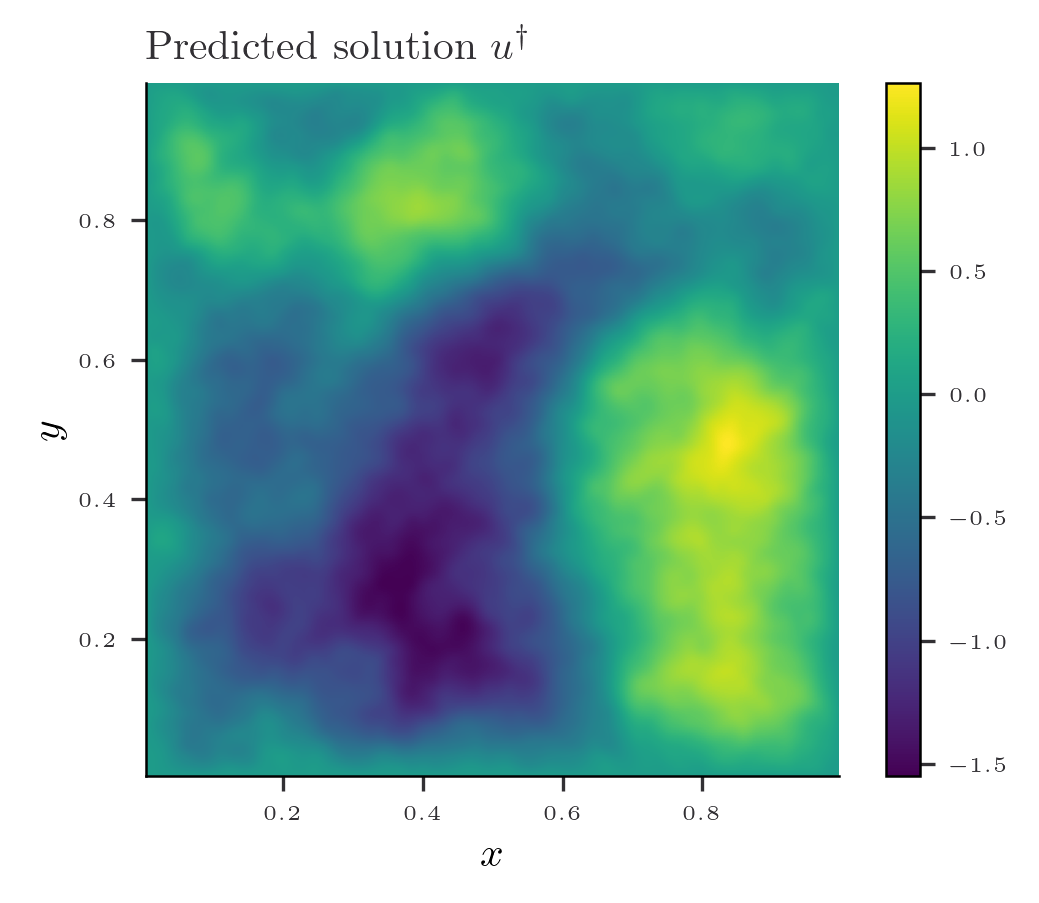

In [35]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

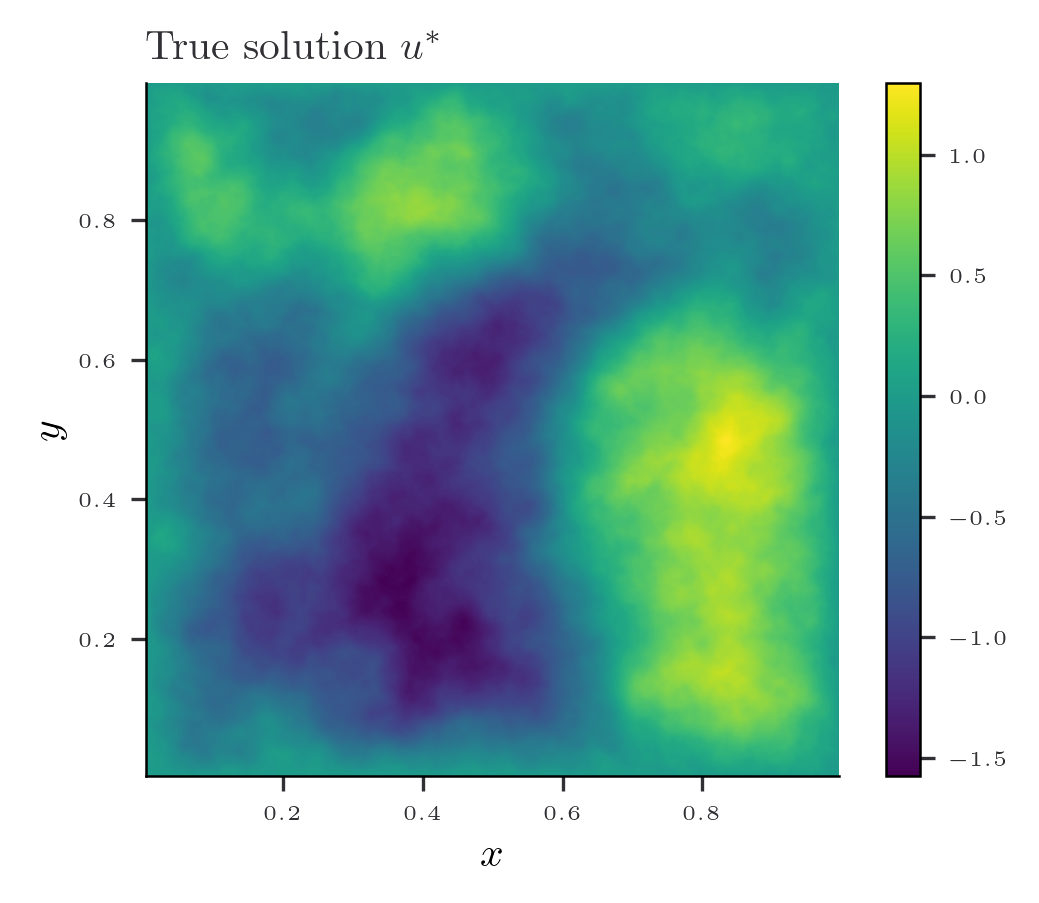

In [36]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

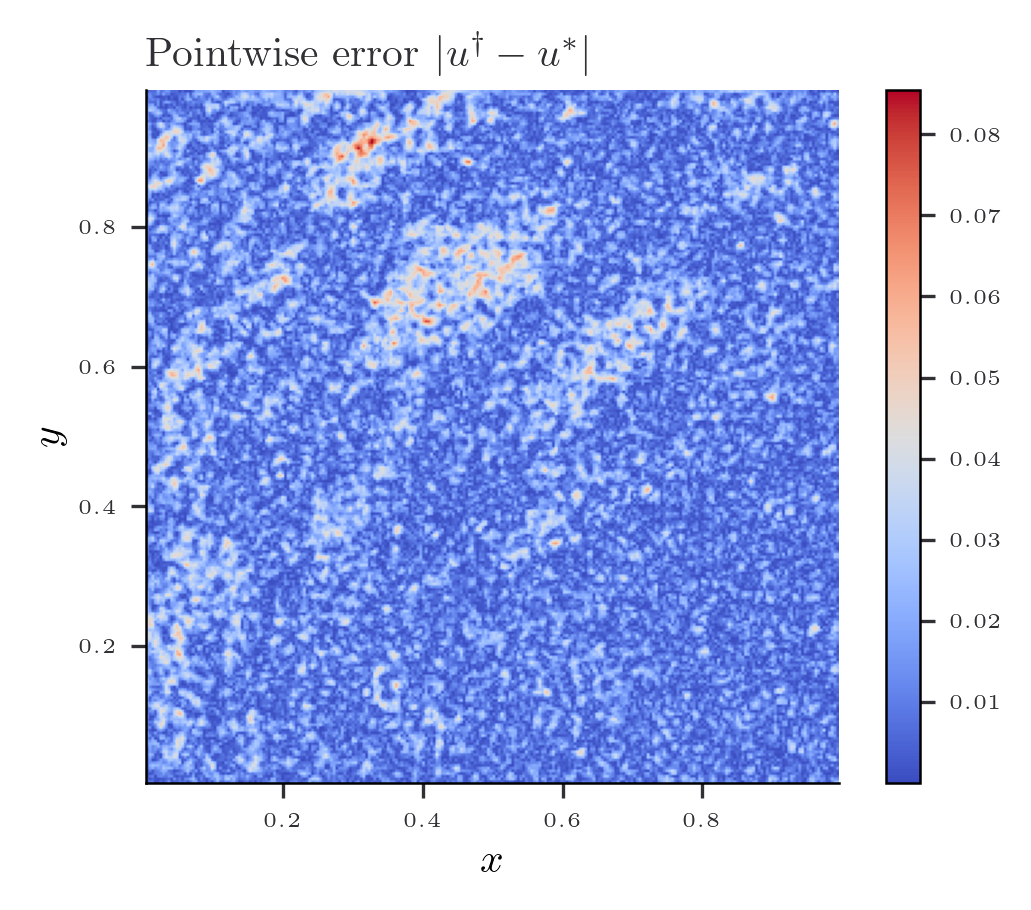

In [37]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

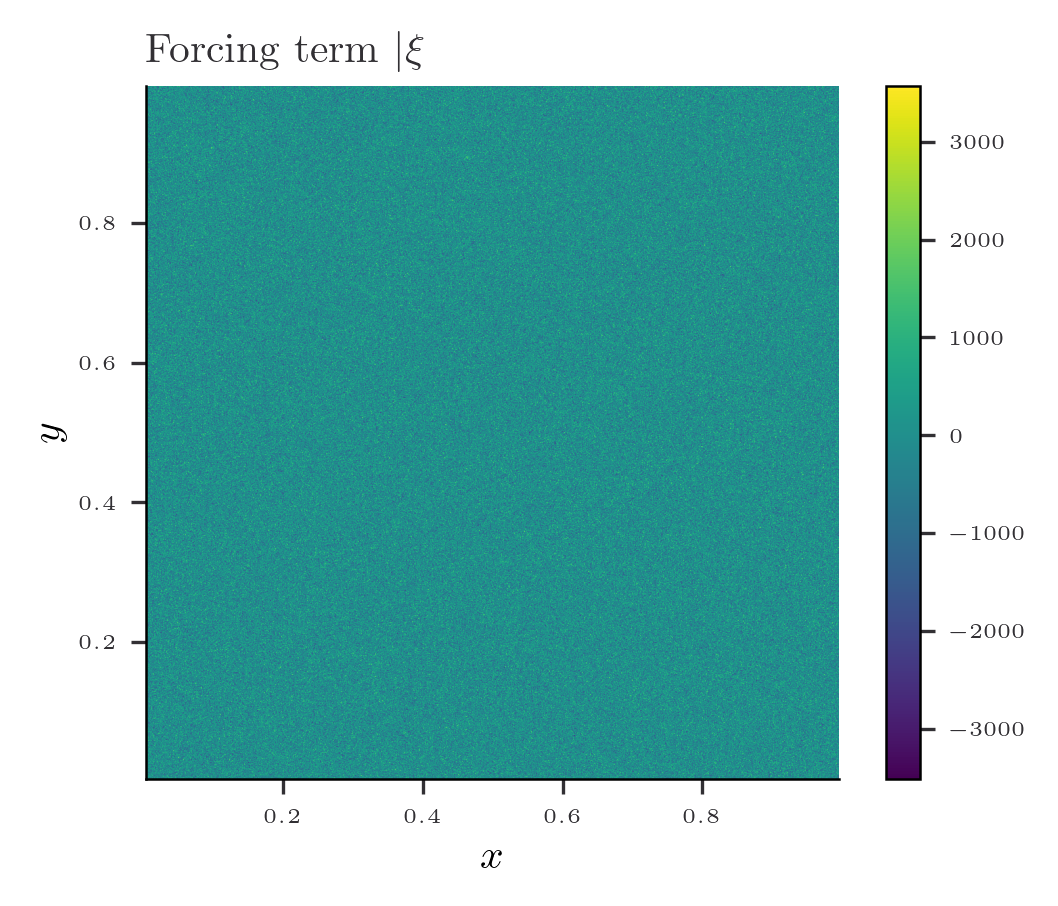

In [38]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $|\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [39]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [40]:
key = random.PRNGKey(647023)

c = 1.0
beta = 0.5

n_coef = 2**10
print("Number of coefficients: ", n_coef)

nu = 1e-1
b = jit(lambda x, y:1)#jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:] # make sure to exclude the points 0 and 1!
y_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x_finest, y_finest)
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef) + 1

delta = 0.025
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))


decay = (jnp.arange(1,n_coef + 1)[None]**2 + jnp.arange(1,n_coef+1)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))

Number of coefficients:  1024


In [41]:
s = 1 -2*delta # Where the right hand side lives (not included). The limit is H^{-1}
s

0.95

In [42]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)

In [43]:
u_values = dst_2d(coef_u)
f_values = dst_2d(coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values)

In [44]:
coef_f = compute_sine_coef_2d(f_values)
print(jnp.mean(jnp.abs(coef_u - compute_sine_coef_2d(u_values))))

1.6026921844310666e-19


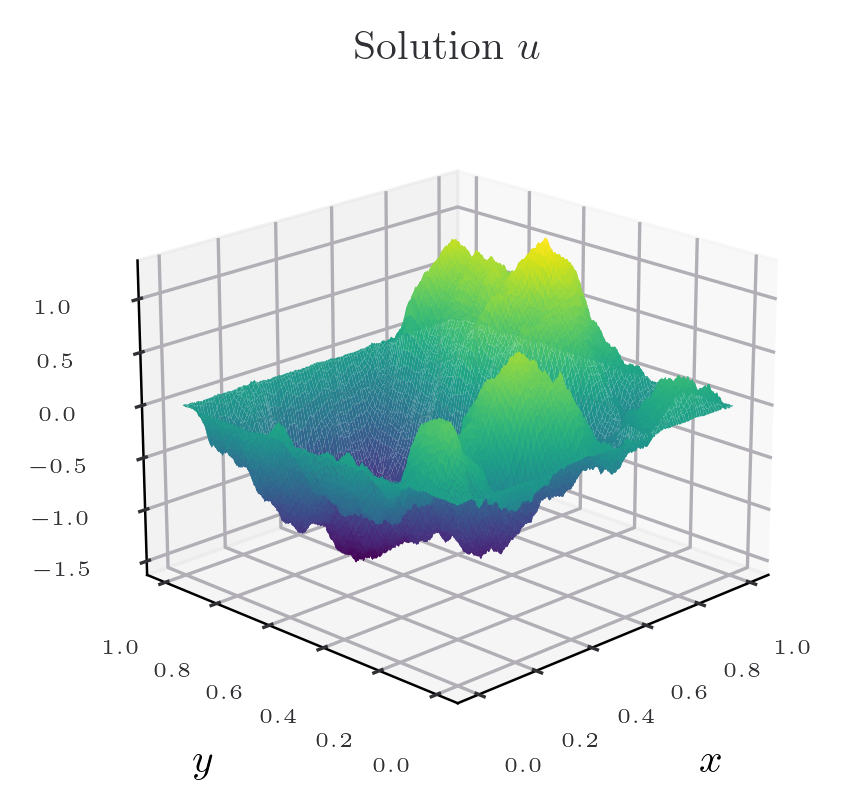

In [45]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 10
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

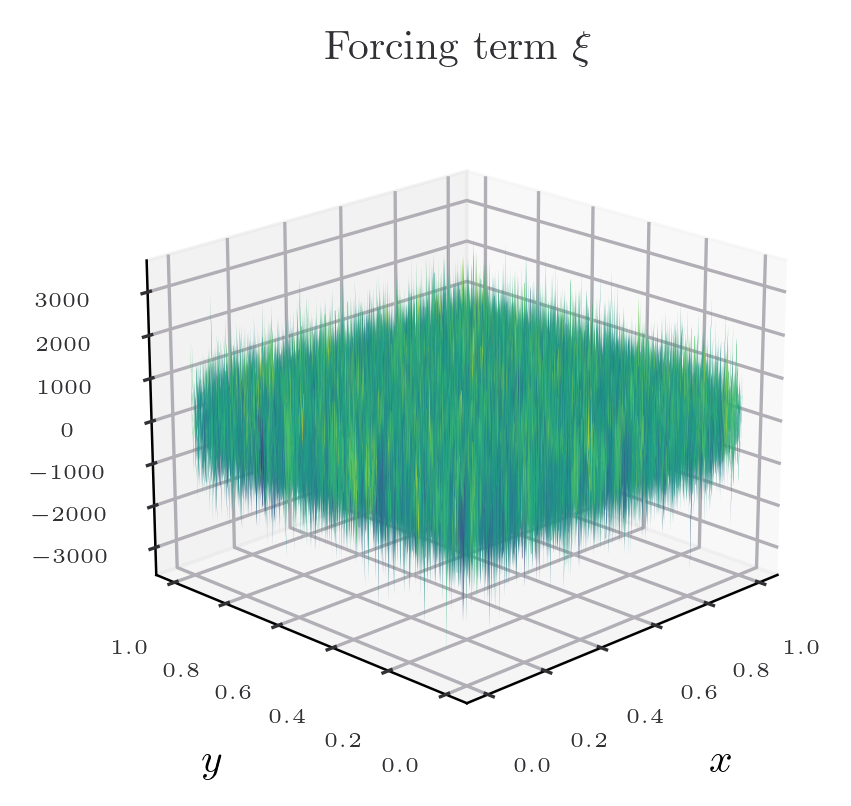

In [46]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

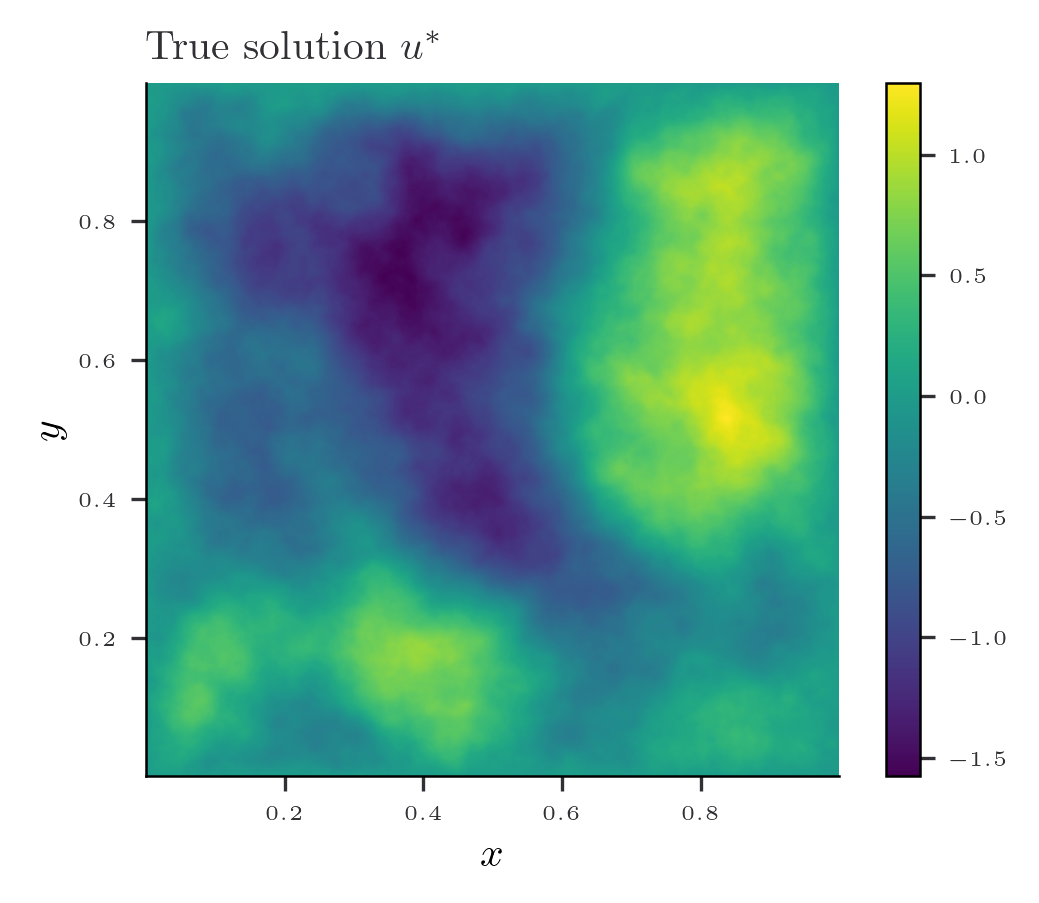

In [47]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

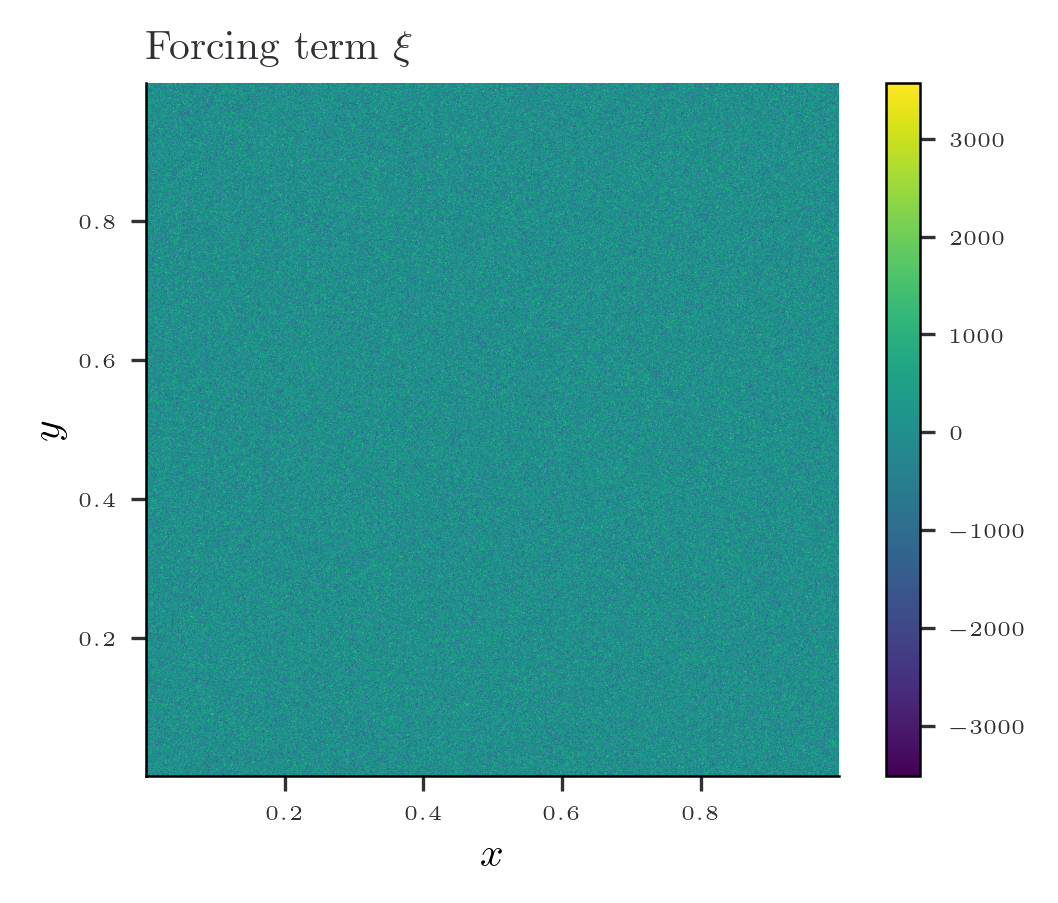

In [48]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

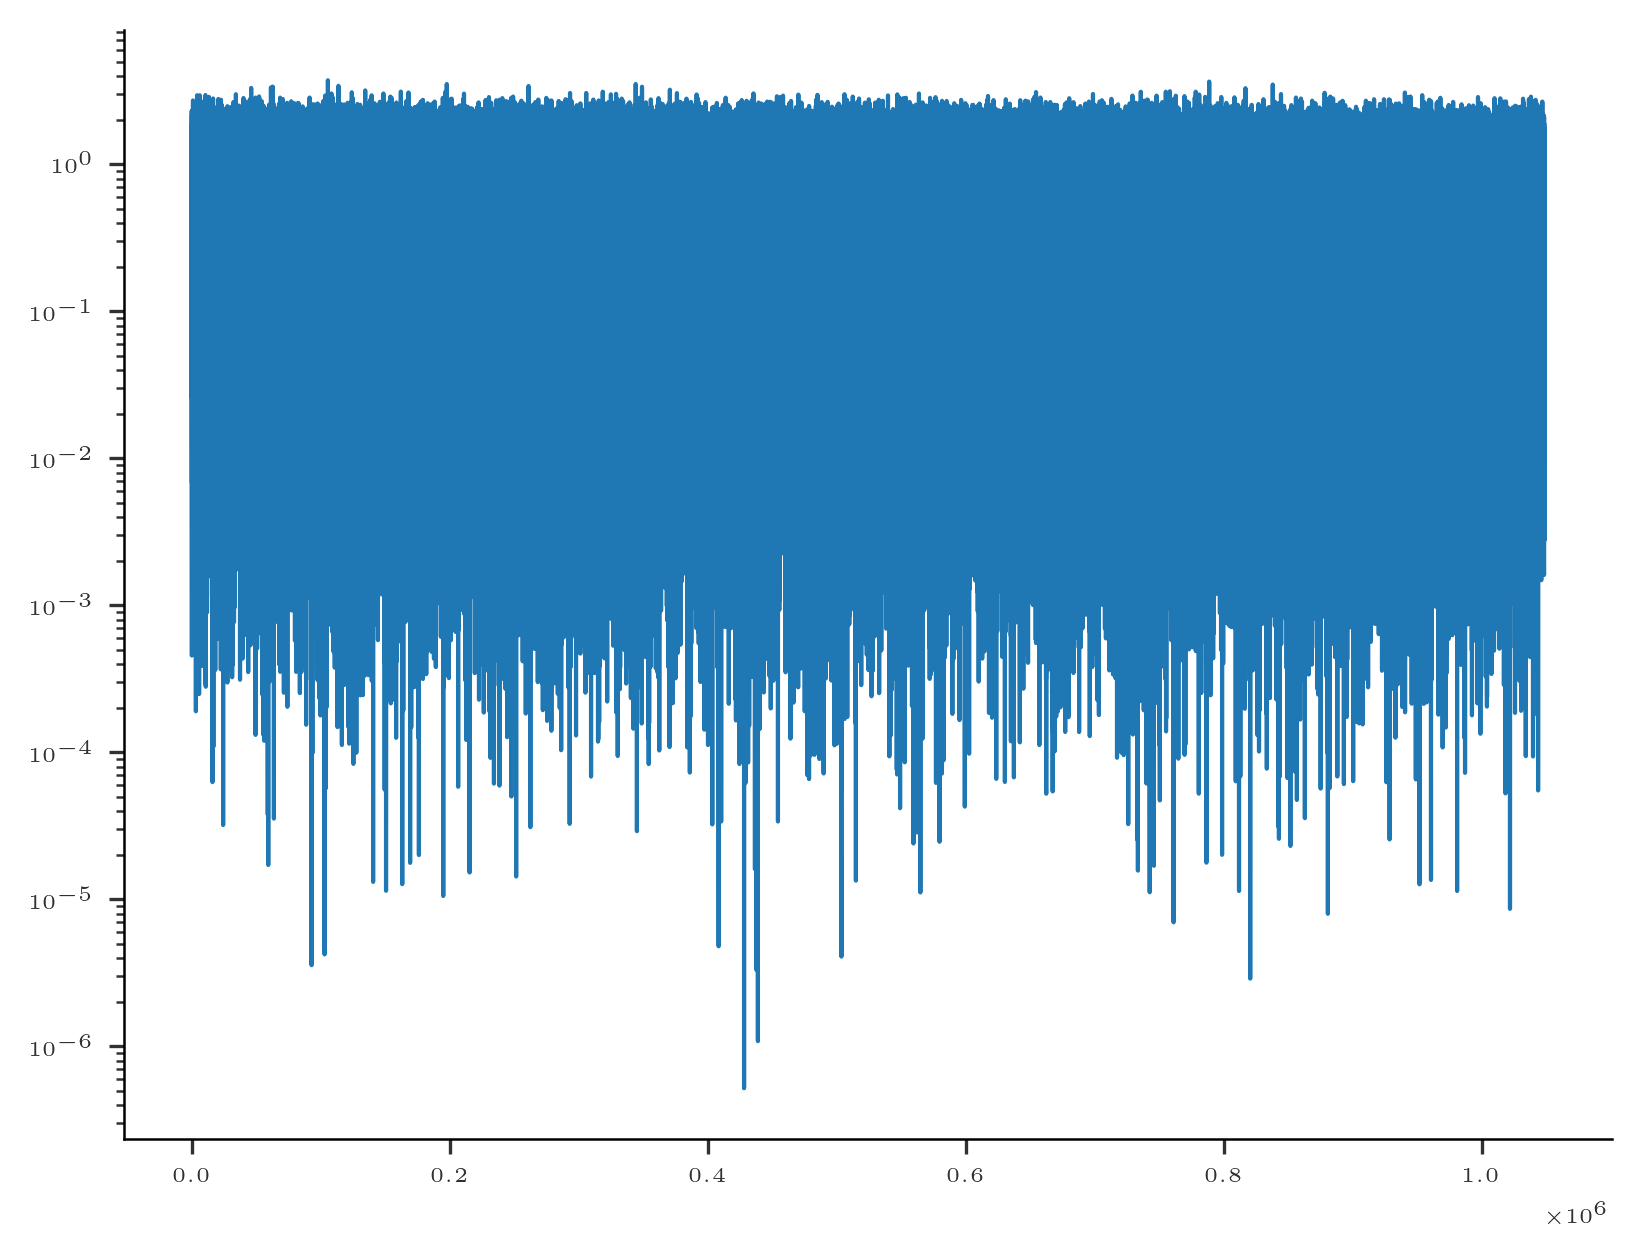

In [49]:
plt.plot(jnp.abs(coef_f.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

## Setting up the Gauss-Newton algorithm



With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.


In [50]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:] # remember to not include the points 0 and 1
y = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

Number of points 64 (4096 measurements)
(4096, 2)


In [51]:
# Create the boundary

# Create a boundary
# Boundary points
boundary = jnp.hstack([jnp.zeros(1), x, jnp.zeros(1)])
n_boundary = boundary.shape[0]
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 66 (264 total)


In [52]:
n_eval = 2**8
x_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
y_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

ratio = int(n_coef/n_eval)
u_eval = u_values[::ratio, ::ratio]

In [53]:
f_observed =  coef_f[:n_points,:n_points]
b_matrix = vmap_b(x, y)
b_matrix_linear = jnp.copy(b_matrix)

In [54]:
u_grid = u_values[::int(n_coef/n_points), ::int(n_coef/n_points)]

In [55]:
def Gauss_Newton(f, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay, reg, reg_bc):
    b_matrix = jnp.copy(b_matrix_linear)
    r_n = f
    n_points = f.shape[0]
    previous_error = jnp.inf
    
    for i in range(n_iter):
        print("Current iteration {}, current error {}".format(i+1, previous_error))

        # Build the matrix and sovle the system
        theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
        alpha = solve(theta, boundary_condition, r_n, s_decay, reg_bc = reg_bc, reg = reg)

        # Evaluate on the grid
        pred_grid, pred = predict(alpha, x, y, x,y, boundary_points, length_scale, nu, b_matrix)

        # Evaluate the DST transform of  negative laplacian 
        K_laplacian_dst = jnp.vstack([theta_12_dst, theta_22_dst]).T
        L_dst = K_laplacian_dst@alpha

        # Compute the discrepancy with f
        error = jnp.linalg.norm(L_dst + compute_sine_coef_2d(tau(pred_grid)).reshape(n_points*n_points) - f.reshape(n_points*n_points))/jnp.linalg.norm(f.reshape(n_points*n_points))
        if jnp.abs(previous_error - error)/jnp.abs(error) < 1e-10:
            print("Converged at iteration {} with error {}".format(i+1, error))
            break
            return alpha, b_matrix, r_n
        previous_error = error


        if i < n_iter-1:
            # Compute the linearization
            linearization = tau_prime(pred_grid)*pred_grid - tau(pred_grid)
            # Project on the sine basis
            linearization = compute_sine_coef_2d(linearization)
            # Compute the residual
            r_n = f + linearization

            # Compute the new coefficent b
            b_matrix = b_matrix_linear + tau_prime(pred_grid)
    return alpha, b_matrix, r_n
    

In [56]:
length_scale = 1.25
nu

0.1

In [77]:
reg = 1e-8

## $L^2$ norm

In [78]:
s_decay = 0.0

In [79]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg = reg, reg_bc = 1e-10)
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

Current iteration 1, current error inf
Current iteration 2, current error 0.013367271490925777
Current iteration 3, current error 0.028938334207383187
Current iteration 4, current error 0.027413287801917728
Current iteration 5, current error 0.02723161227454174
Current iteration 6, current error 0.027127281825105255
Current iteration 7, current error 0.027066880581123196
Current iteration 8, current error 0.027033095007189884
Current iteration 9, current error 0.027014604585476998
Current iteration 10, current error 0.027004609786530697
Current iteration 11, current error 0.026999243099841273
Current iteration 12, current error 0.026996373190866008
Current iteration 13, current error 0.026994840467998153
Current iteration 14, current error 0.02699402292503373
Current iteration 15, current error 0.026993586849400373
Current iteration 16, current error 0.02699335552490818
Current iteration 17, current error 0.02699323125423368
Current iteration 18, current error 0.026993164826655668
Curr

## $H^{-1/2}$ norm

In [80]:
s_decay = 0.5

In [81]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg = 1e-7, reg_bc = 1e-10)
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

Current iteration 1, current error inf
Current iteration 2, current error 0.6267148644181985
Current iteration 3, current error 0.627408398547622
Current iteration 4, current error 0.6273304947710406
Current iteration 5, current error 0.6273258274174319
Current iteration 6, current error 0.6273246534363495
Current iteration 7, current error 0.6273244121842915
Current iteration 8, current error 0.6273243630950321
Current iteration 9, current error 0.6273243530885767
Current iteration 10, current error 0.6273243510499925
Current iteration 11, current error 0.6273243506551007
Current iteration 12, current error 0.627324350565354
Converged at iteration 12 with error 0.6273243505487682
0.022137973844005985 0.0343955380381403


## $H^{-s}$ norm

In [82]:
s_decay = s

In [83]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg = reg, reg_bc = 1e-10)
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

Current iteration 1, current error inf
Current iteration 2, current error 0.7845147281229341
Current iteration 3, current error 0.7850550788669439
Current iteration 4, current error 0.7849941045386627
Current iteration 5, current error 0.7849921499571149
Current iteration 6, current error 0.7849918870418726
Current iteration 7, current error 0.7849918616404614
Current iteration 8, current error 0.7849918592379611
Current iteration 9, current error 0.7849918590135976
Converged at iteration 9 with error 0.7849918589917606
0.02479018879584504 0.038516256623504615


## $H^{-s -\varepsilon}$ norm

In [84]:
s_decay = s + 0.01

In [85]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg = reg, reg_bc = 1e-10)
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

Current iteration 1, current error inf
Current iteration 2, current error 0.7915929769062847
Current iteration 3, current error 0.7921278020774243
Current iteration 4, current error 0.7920673576285056
Current iteration 5, current error 0.792065486325998
Current iteration 6, current error 0.7920652438904112
Current iteration 7, current error 0.7920652215088361
Current iteration 8, current error 0.7920652194927509
Current iteration 9, current error 0.792065219313329
Converged at iteration 9 with error 0.7920652192977657
0.025046302892039532 0.03891417841164273


## $H^{-1}$ norm

In [66]:
s_decay = 1.0

In [67]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg =reg, reg_bc = 1e-10)
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

Current iteration 1, current error inf
Current iteration 2, current error 0.9289894331949368
Current iteration 3, current error 0.929415141036415
Current iteration 4, current error 0.9293626268583034
Current iteration 5, current error 0.9293622631861512
Current iteration 6, current error 0.9293622300030531
Current iteration 7, current error 0.9293622291189687
Converged at iteration 7 with error 0.9293622291002244
0.03845363587809942 0.059745011213303854


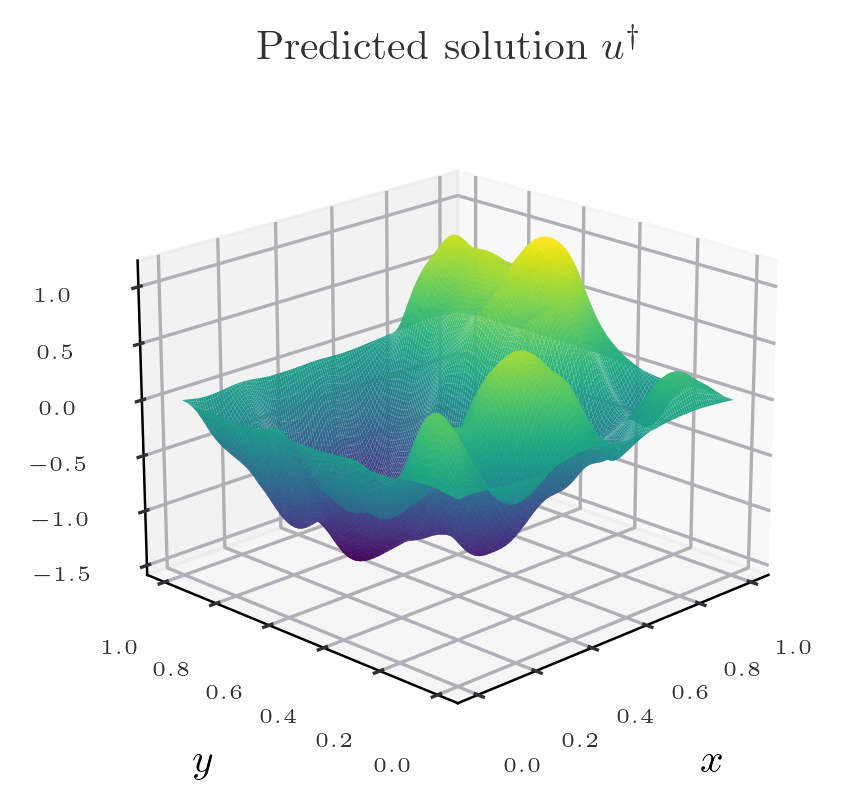

In [68]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 2
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

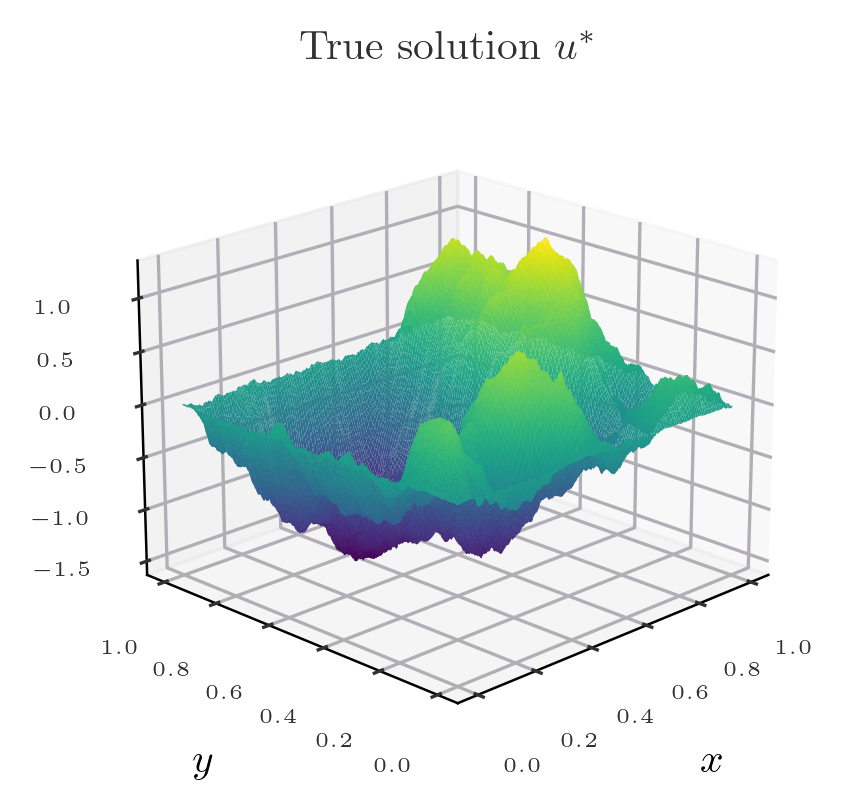

In [69]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

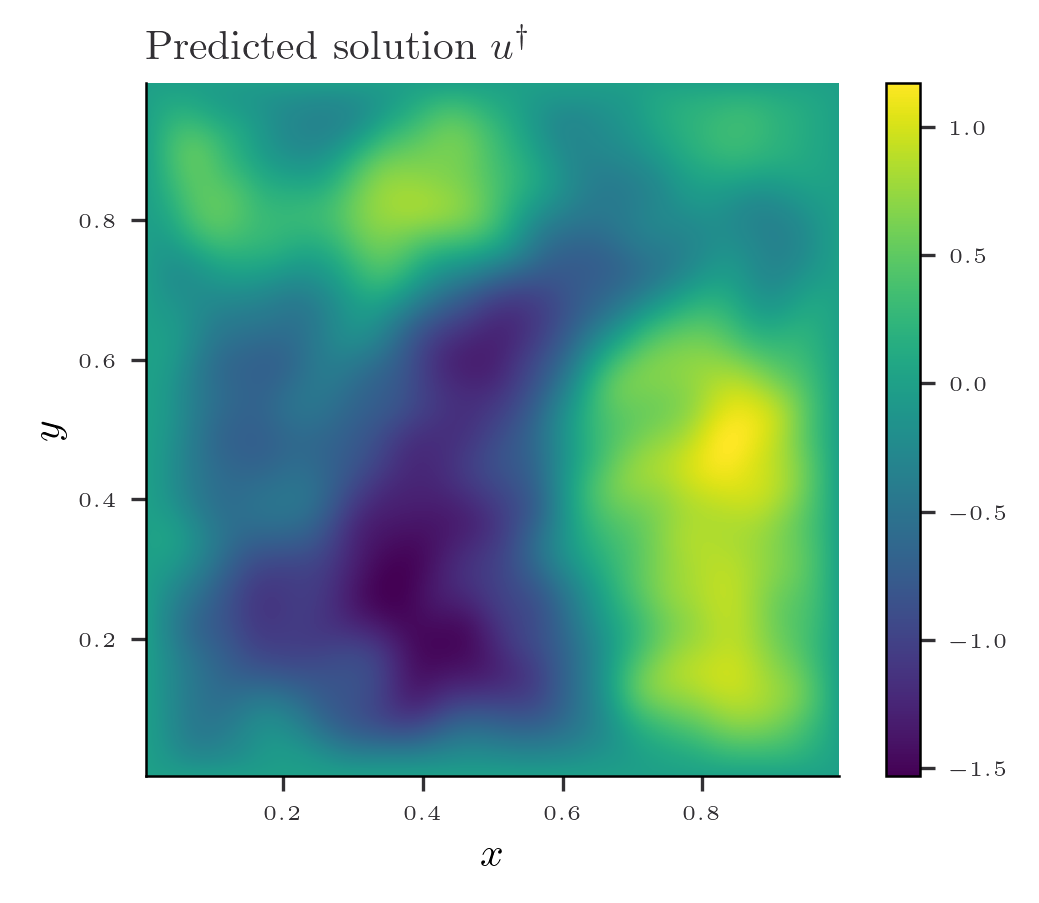

In [70]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

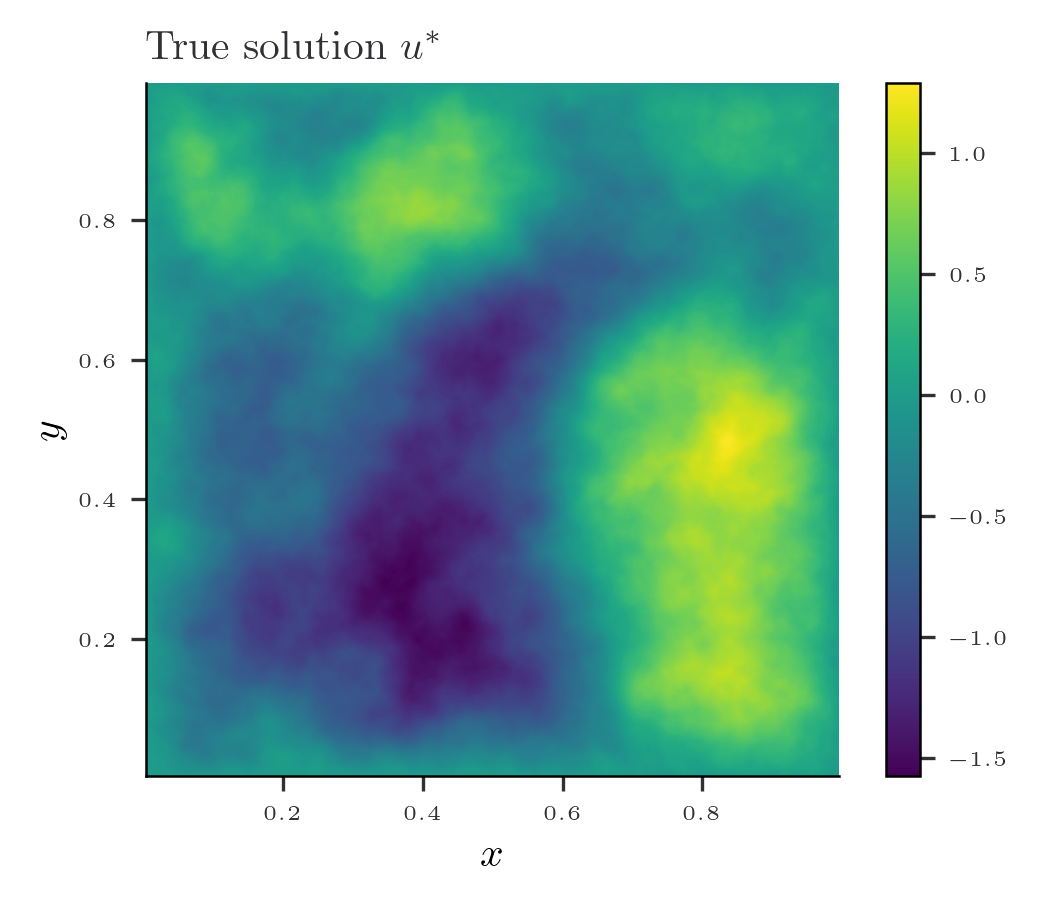

In [71]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_eval, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

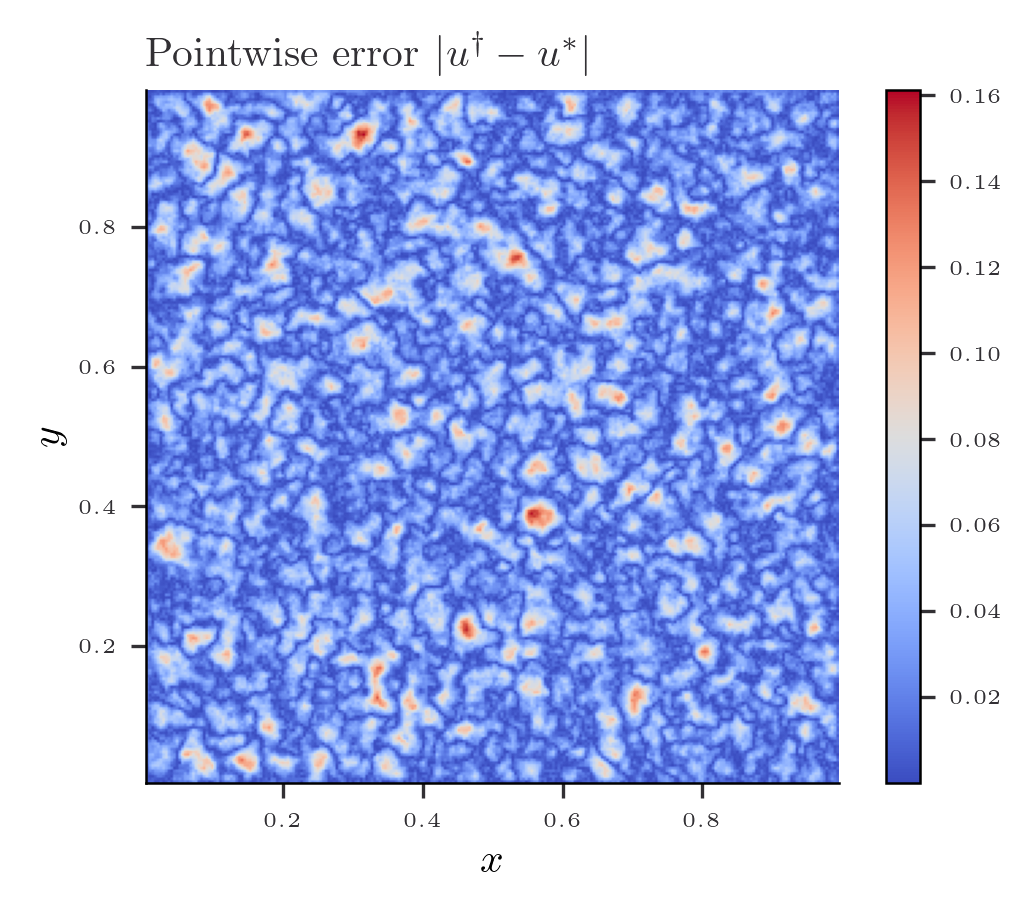

In [72]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()